# Adult-PMR3508

Esse trabalho se propõe a realizar a predição da renda anual a partir de dados demográficos contidos na base Adult, disponível no repositório ICU. Para tanto, será utilizado o algoritmo KNN, aliado a técnicas de pré-processamento.

## 1. Importação das bibliotecas

In [1]:
!pip install missingno -q

In [2]:
#matemática
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#gráficos
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

#missing data
import missingno as msno

#pré-processamento
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler

#cross validation
from sklearn.model_selection import KFold

#KNN
from sklearn.neighbors import KNeighborsClassifier

#avaliação
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, RocCurveDisplay

#matriz de confusão
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

## 2. Importação dos dados

In [3]:
df = pd.read_csv("/kaggle/input/adult-pmr3508/train_data.csv" ,
        engine = "python",
        sep=r'\s*,\s*',
        na_values="?")

final_test = pd.read_csv("/kaggle/input/adult-pmr3508/test_data.csv", 
        engine = "python",
        sep=r'\s*,\s*',
        na_values="?")

In [4]:
df.shape #verificação do número de linhas e colunas

(32560, 16)

In [5]:
df.head() 

,Id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,16280,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
1,16281,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
2,16282,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
3,16283,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
4,16284,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K


In [6]:
#separação do desfecho das variáveis preditoras
X = df.drop(columns = ["income", "Id"])
y = df["income"]
final_test = final_test.drop(columns = "Id")

In [7]:
X.shape

(32560, 14)

In [8]:
y

0        <=50K
1        <=50K
2        <=50K
3        <=50K
4         >50K
         ...  
32555     >50K
32556    <=50K
32557    <=50K
32558    <=50K
32559    <=50K
Name: income, Length: 32560, dtype: object

## 3. Análise exploratória de dados

### 3.1 Informações gerais

In [9]:
#obtenção de informações sobre os tipos de variáveis no conjunto de dados
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32560 non-null  int64 
 1   workclass       30724 non-null  object
 2   fnlwgt          32560 non-null  int64 
 3   education       32560 non-null  object
 4   education.num   32560 non-null  int64 
 5   marital.status  32560 non-null  object
 6   occupation      30717 non-null  object
 7   relationship    32560 non-null  object
 8   race            32560 non-null  object
 9   sex             32560 non-null  object
 10  capital.gain    32560 non-null  int64 
 11  capital.loss    32560 non-null  int64 
 12  hours.per.week  32560 non-null  int64 
 13  native.country  31977 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


In [10]:
#separação das variáveis em categóricas e numéricas a fim de facilitar seu processamento
numeric_features = ["age", "fnlwgt", "capital.gain", "capital.loss", "hours.per.week", "education.num"] 
categorical_features = ["workclass",  "marital.status", "occupation", "relationship", "race", "sex", "native.country"]

### 3.2 Análise de missing values

Nesse banco de dados, os valores faltantes estão representados pelo símbolo '?', portanto, o substituiremos por NaN, para facilitar sua vizualização e processamento.

In [11]:
X.replace(to_replace='?',value= np.nan,inplace=True) #substituir '?' por missing

<Axes: >

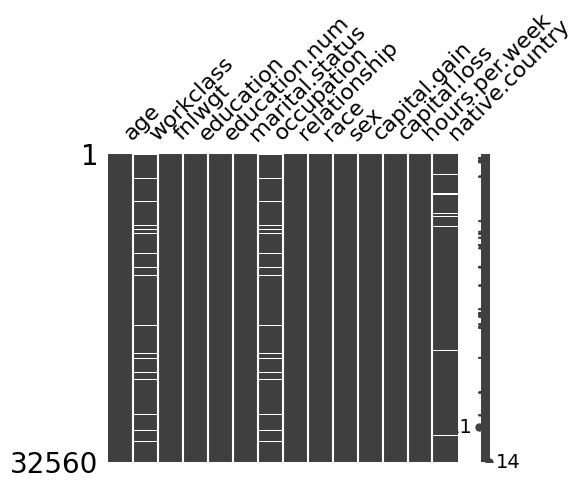

In [12]:
msno.matrix(X, figsize = (5, 4)) #matriz de valores faltante

In [13]:
X.isna().sum().sort_values(ascending = False) #verificar número de valores faltantes em cada variável

occupation        1843
workclass         1836
native.country     583
age                  0
fnlwgt               0
education            0
education.num        0
marital.status       0
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
dtype: int64

Vemos que três variáveis possuem valores faltantes, sendo que, conforme pode ser visto da matriz, sua ausência parece apresentar alto grau de conservação (os mesmos índices apresentam valores faltantes nas variáveis).

#### 3.2.1 Remoção de variáveis com mais de 80% de dados faltantes

In [14]:
for coluna in X.columns:
    prop = X[coluna].isna().astype(int).sum()/len(X) #cálculo da proporção de valores faltantes na coluna
    if prop > 0.8:
        X.drop(columns = coluna) #remover coluna com mais de 80% de missing
        print("A coluna %s for removida"%coluna) #imprimir colunas removidas, para controle

Aparentemente, não foi necessária a remoção de nenhuma coluna devido a insuficiência de dados.

### 3.3 Análise descritiva

In [15]:
X.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32560.000,32560.000,32560.000,32560.000,32560.000,32560.000
mean,38.582,189781.814,10.081,1077.615,87.307,40.437
std,13.641,105549.765,2.573,7385.403,402.966,12.348
min,17.000,12285.000,1.000,0.000,0.000,1.000
25%,28.000,117831.500,9.000,0.000,0.000,40.000
50%,37.000,178363.000,10.000,0.000,0.000,40.000
75%,48.000,237054.500,12.000,0.000,0.000,45.000
max,90.000,1484705.000,16.000,99999.000,4356.000,99.000


### 3.4 Visualização gráfica

#### 3.4.1 BoxPlots

In [16]:
for feature in numeric_features:
    fig = px.box(X, x=feature, color=y, title=feature)
    fig.show()

Analisando os boxplots das variáveis numéricas estratificados pelo desfecho, observamos que há uma diferença significativa entre grupos em se tratando das variáveis idade e número de anos de estudo, sugerindo que estes devem ser preditores fortes do desfecho. 

#### 3.4.2 Histogramas

In [17]:
for i, feature in enumerate(numeric_features, 1):
    fig = px.histogram(X, x=feature, color=y, barmode='overlay',
                   title=feature)
    fig.show()

Novamente, vemos que a distribuição entre grupos estratificados pelo desfecho é significativamente diferente, sobretudo na variável idade.

## 4. Pré-processamento de Dados

### 4.1. Divisão treino-teste

Separamos 30% dos dados para simular dados reais (inéditos) para testar o modelo, enquanto os demais 70% serão usados no treinamento.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7) #divisão treino-teste com razão 70:30

O desfecho será representado como uma variável binária tal que 0 representa o grupo que recebe menos ou igual a 50K, ao passo que 1 indica aquelas pessoas que recebem valores maiores que 50K.

In [19]:
y_train, y_test = y_train.apply(lambda x: 1 if x == '>50K' else 0), y_test.apply(lambda x: 1 if x == '>50K' else 0) #binarização do desfecho

### 4.2 Processamento de variáveis categóricas

In [20]:
categorical_features

['workclass',
 'marital.status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native.country']

#### 4.2.1 Workclass

In [21]:
X_train['workclass'].isna().sum() #verificação do número de dados faltantes

1281

In [22]:
X_train['workclass'] = X_train['workclass'].fillna("Unknown") #criação de classe "Unknown" para dados missing

In [23]:
X_train['workclass'].value_counts(normalize=True) #verificar distribuição das classes da variável

workclass
Private            0.696
Self-emp-not-inc   0.078
Local-gov          0.065
Unknown            0.056
State-gov          0.040
Self-emp-inc       0.035
Federal-gov        0.029
Without-pay        0.001
Never-worked       0.000
Name: proportion, dtype: float64

Nota-se que há uma prevalência da classe de trabalhadores privados (70%), mas as demais classes são razoavelmente bem distribuídas.

In [24]:
#gerar histograma de classe de trabalho estratificada por desfecho no conjunto de treinamento
#note que o desfecho do conjunto de teste permanece desconhecido
fig = px.histogram(X_train, x='workclass', color=y_train, barmode='overlay',
                   title=feature)
fig.show()

In [25]:
pd.crosstab(X_train["workclass"], y_train, normalize='index').sort_values(by=1,
ascending = False) #verificação do percentual de desfecho por classe no conjunto de treinamento

income,0,1
workclass,,
Self-emp-inc,0.435,0.565
Federal-gov,0.598,0.402
Local-gov,0.695,0.305
Self-emp-not-inc,0.714,0.286
State-gov,0.728,0.272
Private,0.776,0.224
Unknown,0.901,0.099
Never-worked,1.000,0.000
Without-pay,1.000,0.000


Avaliando as proporções de desfecho por classe no conjunto de treinamento, criaremos novas categorias que agrupem profissões com percentuais similares de desfecho.

In [26]:
#separar profissões por receita anual
high = [ 'Self-emp-inc', 'Federal-gov']
medium = [ 'Local-gov','Self-emp-not-inc','State-gov',  'Private']
low = ['Unknown', 'Never-worked', 'Without-pay']


Utilizaremos essas novas categorias para realizar o one hot encoding dessa variável, nos conjuntos de treinamento e teste.

In [27]:
X_train["workclass_high"] = X_train["workclass"].apply(lambda x: 1 if x in high else 0)
X_train["workclass_medium"] = X_train["workclass"].apply(lambda x: 1 if x in medium else 0)
X_train["workclass_low"] = X_train["workclass"].apply(lambda x: 1 if x in low else 0)
X_train = X_train.drop(columns = "workclass")

In [28]:
X_test["workclass_high"] = X_test["workclass"].apply(lambda x: 1 if x in high else 0)
X_test["workclass_medium"] = X_test["workclass"].apply(lambda x: 1 if x in medium else 0)
X_test["workclass_low"] = X_test["workclass"].apply(lambda x: 1 if x in low else 0)
X_test = X_test.drop(columns = "workclass")

In [29]:
final_test["workclass_high"] = final_test["workclass"].apply(lambda x: 1 if x in high else 0)
final_test["workclass_medium"] = final_test["workclass"].apply(lambda x: 1 if x in medium else 0)
final_test["workclass_low"] = final_test["workclass"].apply(lambda x: 1 if x in low else 0)
final_test = final_test.drop(columns = "workclass")

#### 4.2.2 Education

In [30]:
X_train['education'].value_counts(normalize=True) #verificação da distribuição entre classes da variável

education
HS-grad        0.321
Some-college   0.224
Bachelors      0.164
Masters        0.053
Assoc-voc      0.043
11th           0.036
Assoc-acdm     0.033
10th           0.028
7th-8th        0.020
Prof-school    0.019
9th            0.016
Doctorate      0.013
12th           0.013
5th-6th        0.010
1st-4th        0.005
Preschool      0.002
Name: proportion, dtype: float64

In [31]:
#histograma estratficado pelo desfecho do conjunto de treinamento
fig = px.histogram(X_train, x='education', color=y_train, barmode='overlay',
                   title=feature)
fig.show()

In [32]:
#proporção de desfecho em cada classe avaliada sobre o conjunto de treinamento
crosstab= pd.crosstab(X_train["education"], y_train, normalize='index').sort_values(by=1,
ascending = False)
crosstab

income,0,1
education,,
Prof-school,0.252,0.748
Doctorate,0.285,0.715
Masters,0.436,0.564
Bachelors,0.578,0.422
Assoc-voc,0.736,0.264
Assoc-acdm,0.754,0.246
Some-college,0.802,0.198
HS-grad,0.836,0.164
12th,0.934,0.066


In [33]:
#estabelecer novas categorias de acordo com as proporções de desfecho
high = []
medium= []
low= []

#os valores de corte (0.400 e 0.150) foram estipulados observando o padrão de dispersão dos dados na tabela anterior
for feature in set(X_train['education'].values):
    if float(crosstab.loc[feature][1]) > 0.400:
        high.append(feature)
    elif float(crosstab.loc[feature][1]) > 0.150:
        medium.append(feature)
    else:
        low.append(feature)

In [34]:
#one hot encoding utilizando as novas categorias agrupadas
X_train["education_high"] = X_train["education"].apply(lambda x: 1 if x in high else 0)
X_train["education_medium"] = X_train["education"].apply(lambda x: 1 if x in medium else 0)
X_train["education_low"] = X_train["education"].apply(lambda x: 1 if x in low else 0)
X_train = X_train.drop(columns = "education")

In [35]:
#replicação do one hot encoding no conjunto de teste (garantir que hajam as mesmas colunas)
X_test["education_high"] = X_test["education"].apply(lambda x: 1 if x in high else 0)
X_test["education_medium"] = X_test["education"].apply(lambda x: 1 if x in medium else 0)
X_test["education_low"] = X_test["education"].apply(lambda x: 1 if x in low else 0)
X_test = X_test.drop(columns = "education")

In [36]:
final_test["education_high"] = final_test["education"].apply(lambda x: 1 if x in high else 0)
final_test["education_medium"] = final_test["education"].apply(lambda x: 1 if x in medium else 0)
final_test["education_low"] = final_test["education"].apply(lambda x: 1 if x in low else 0)
final_test = final_test.drop(columns = "education")

### 4.3 Marital status

In [37]:
X_train['marital.status'].value_counts(normalize=True) #distribuição das classes

marital.status
Married-civ-spouse      0.463
Never-married           0.326
Divorced                0.136
Separated               0.031
Widowed                 0.031
Married-spouse-absent   0.013
Married-AF-spouse       0.001
Name: proportion, dtype: float64

In [38]:
#histograma estratificado pelo desfecho no conjunto de treinamento
fig = px.histogram(X_train, x='marital.status', color=y_train, barmode='overlay')
fig.show()

Notamos que, nesse caso, o que realmente muda o perfil de desfecho é a pessoa ser casada ou não. Dessa maneira, adaptaremos a variável para uma variável binária, que recebe 1 caso a pessoa seja casada e 0, caso contrário.

In [39]:
#binariação da variável
X_train['marital.status'] = X_train['marital.status'].apply(lambda x: 1 if x == "Married-civ-spouse" else 0)
X_test['marital.status'] = X_test['marital.status'].apply(lambda x: 1 if x == "Married-civ-spouse" else 0)
final_test['marital.status'] = final_test['marital.status'].apply(lambda x: 1 if x == "Married-civ-spouse" else 0)

In [40]:
X_train['marital.status'] #verificar nova variável

6076     1
16820    0
31693    0
21659    1
20218    0
        ..
31092    0
9395     0
8321     1
23528    1
10670    1
Name: marital.status, Length: 22792, dtype: int64

### 4.4 Occupation

In [41]:
X_train['occupation'].isna().any() #verificar se existem valores faltantes

True

In [42]:
#Incluiremos os valores faltantes na classe "outros"
X_train['occupation'] = X_train['occupation'].fillna("Other-service")
X_test['occupation'] = X_test['occupation'].fillna("Other-service")
final_test['occupation'] = final_test['occupation'].fillna("Other-service")

In [43]:
X_train['occupation'].value_counts(normalize=True) #verificação da distribuição de classes

occupation
Other-service       0.157
Prof-specialty      0.130
Craft-repair        0.126
Exec-managerial     0.126
Adm-clerical        0.116
Sales               0.108
Machine-op-inspct   0.062
Transport-moving    0.048
Handlers-cleaners   0.041
Farming-fishing     0.032
Tech-support        0.029
Protective-serv     0.021
Priv-house-serv     0.005
Armed-Forces        0.000
Name: proportion, dtype: float64

In [44]:
#histograma estratificado pelo desfecho no conjunto de treinamento
fig = px.histogram(X_train, x='occupation', color=y_train, barmode='overlay')
fig.show()

In [45]:
#verificarproporção de desfecho por classe no conjunto de treinamento
crosstab= pd.crosstab(X_train["occupation"], y_train, normalize='index').sort_values(by=1,
ascending = False)
crosstab

income,0,1
occupation,,
Exec-managerial,0.505,0.495
Prof-specialty,0.545,0.455
Protective-serv,0.672,0.328
Tech-support,0.706,0.294
Sales,0.719,0.281
Craft-repair,0.771,0.229
Transport-moving,0.790,0.210
Adm-clerical,0.864,0.136
Machine-op-inspct,0.871,0.129


In [46]:
#estabelecer novas categorias por proporção de desfecho nos valores de treino e teste
high = []
medium= []
low= []
#valores de corte estabelecidos por meio da observação do padrão de dispersão dos dados
for feature in set(X_train['occupation'].values):
    if float(crosstab.loc[feature][1]) > 0.400:
        high.append(feature)
    elif float(crosstab.loc[feature][1]) > 0.200:
        medium.append(feature)
    else:
        low.append(feature)

In [47]:
#one hot encoding com base nas novas categorias
X_train["occupation_high"] = X_train["occupation"].apply(lambda x: 1 if x in high else 0)
X_train["occupation_medium"] = X_train["occupation"].apply(lambda x: 1 if x in medium else 0)
X_train["occupation_low"] = X_train["occupation"].apply(lambda x: 1 if x in low else 0)
X_train = X_train.drop(columns = "occupation")

In [48]:
#replicação do one hot encoding no conjunto de teste
X_test["occupation_high"] = X_test["occupation"].apply(lambda x: 1 if x in high else 0)
X_test["occupation_medium"] = X_test["occupation"].apply(lambda x: 1 if x in medium else 0)
X_test["occupation_low"] = X_test["occupation"].apply(lambda x: 1 if x in low else 0)
X_test = X_test.drop(columns = "occupation")

In [49]:
#replicação do one hot encoding no conjunto de teste
final_test["occupation_high"] = final_test["occupation"].apply(lambda x: 1 if x in high else 0)
final_test["occupation_medium"] = final_test["occupation"].apply(lambda x: 1 if x in medium else 0)
final_test["occupation_low"] = final_test["occupation"].apply(lambda x: 1 if x in low else 0)
final_test = final_test.drop(columns = "occupation")

### 4.5 Relashionship

In [50]:
X_train['relationship'].value_counts(normalize=True) #verificação da proporção de classes

relationship
Husband          0.407
Not-in-family    0.254
Own-child        0.156
Unmarried        0.104
Wife             0.049
Other-relative   0.029
Name: proportion, dtype: float64

In [51]:
#histograma estratificado por desfecho no conjunto de treinamento
fig = px.histogram(X_train, x='relationship', color=y_train, barmode='overlay')
fig.show()

Nota-se que aqui a diferença é ser casado ou não, como essa informação já foi registrada em marital status, não é necessário incluir essa variável. 

In [52]:
#remoção da coluna, visto que ela é redundante com 'marital status'
X_train = X_train.drop(columns = "relationship")
X_test = X_test.drop(columns = "relationship")
final_test = final_test.drop(columns = "relationship")

### 4.6 Race

In [53]:
X_train['race'].value_counts(normalize=True) #verificar proporção de classes

race
White                0.854
Black                0.095
Asian-Pac-Islander   0.033
Amer-Indian-Eskimo   0.010
Other                0.009
Name: proportion, dtype: float64

In [54]:
#histograma estratificado pelo desfecho no conjunto de teste
fig = px.histogram(X_train, x='race', color=y_train, barmode='overlay')
fig.show()

Essa variável é muito desbalanceada em termos de número de observações, portanto não é informativa para o modelo, visto que as classes de pessoas não brancas somadas não ultrapassam 15%, sendo insuficientemente representadas para permitir predições relevantes.

In [55]:
#eliminar coluna 
X_train= X_train.drop(columns = "race")
X_test = X_test.drop(columns = "race")
final_test = final_test.drop(columns = "race")

In [56]:
X_train.head() #verificar se a coluna foi corretamente eliminada

,age,fnlwgt,education.num,marital.status,sex,capital.gain,capital.loss,hours.per.week,native.country,workclass_high,workclass_medium,workclass_low,education_high,education_medium,education_low,occupation_high,occupation_medium,occupation_low
6076,44,328561,11,1,Female,0,0,20,United-States,0,1,0,0,1,0,0,0,1
16820,25,200681,10,0,Male,0,0,40,United-States,0,0,1,0,1,0,0,0,1
31693,41,197069,10,0,Male,4650,0,40,United-States,1,0,0,0,1,0,0,0,1
21659,35,348771,7,1,Male,0,0,36,United-States,0,1,0,0,0,1,0,1,0
20218,46,182715,4,0,Male,0,0,40,United-States,0,1,0,0,0,1,1,0,0


### 4.7 Sex

Nesse caso, basta binarizar a variável.

In [57]:
X_train['sex'] = X_train['sex'].apply(lambda x: 1 if x == "Male" else 0)
X_test['sex'] = X_test['sex'].apply(lambda x: 1 if x == "Male" else 0)
final_test['sex'] = final_test['sex'].apply(lambda x: 1 if x == "Male" else 0)

In [58]:
#histograma estratificado pelo desfecho no conjunto de teste
fig = px.histogram(X_train, x='sex', color=y_train, barmode='overlay')
fig.show()

De fato, as observações sugerem um forte viés salarial, com maiores valores para os indivíduos do sexo masculino.

### 4.8 Native Country

In [59]:
X_train['native.country'].value_counts(normalize=True) #verificação da distribuição de classes

native.country
United-States                0.913
Mexico                       0.019
Philippines                  0.006
Germany                      0.004
Puerto-Rico                  0.004
Canada                       0.004
El-Salvador                  0.003
England                      0.003
India                        0.003
Cuba                         0.003
South                        0.003
Jamaica                      0.003
China                        0.003
Dominican-Republic           0.002
Italy                        0.002
Vietnam                      0.002
Japan                        0.002
Columbia                     0.002
Guatemala                    0.002
Poland                       0.002
Taiwan                       0.001
Haiti                        0.001
Iran                         0.001
Nicaragua                    0.001
Portugal                     0.001
France                       0.001
Greece                       0.001
Peru                         0.001
Ecuad

Essa variável é muito desbalanceada em termos de número de observações, portanto não é informativa para o modelo, visto que os nativos dos Estados Unidos representam mais de 90% das observações, com a próxima classe mais frequente (México) não chegando a 2%. 

In [60]:
#eliminação da coluna dos conjuntod=s de treino e teste
X_train= X_train.drop(columns = "native.country")
X_test = X_test.drop(columns = "native.country")
final_test = final_test.drop(columns = "native.country")

### 4.9 Verificar consistência

In [61]:
#indicar se há alguma coluna presente no conjunto de treinamento que não está presente no teste
for coluna in X_train.columns:
    if coluna not in X_test.columns:
        print(coluna)

In [62]:
#indicar se há alguma coluna presente no conjunto de teste que não está presente no treinamento
for coluna in X_test.columns:
    if coluna not in X_train.columns:
        print(coluna)

Todas as colunas estão consistentes entre treino e teste após a criação das novas categorias. 

In [63]:
X_train.head() #checagem do conjunto de dados após tratamento dos atributos categóricos

,age,fnlwgt,education.num,marital.status,sex,capital.gain,capital.loss,hours.per.week,workclass_high,workclass_medium,workclass_low,education_high,education_medium,education_low,occupation_high,occupation_medium,occupation_low
6076,44,328561,11,1,0,0,0,20,0,1,0,0,1,0,0,0,1
16820,25,200681,10,0,1,0,0,40,0,0,1,0,1,0,0,0,1
31693,41,197069,10,0,1,4650,0,40,1,0,0,0,1,0,0,0,1
21659,35,348771,7,1,1,0,0,36,0,1,0,0,0,1,0,1,0
20218,46,182715,4,0,1,0,0,40,0,1,0,0,0,1,1,0,0


## 5. Tratamento das variáveis numéricas

Para assegurar melhor performance do modelo, normalizaremos todas as variáveis numéricas por uma transformação z-score, de modo a evitar que as medidas de distância realizadas pelo KNN sejam distorcidas pelas diferentes escalas acabando por privilegiar alguma variável em detrimento das demais.

In [64]:
#transformação z-score
scaler = StandardScaler()

for feature in numeric_features:
    scaler.fit(X_train[[feature]])
    X_train[feature] = scaler.transform(X_train[[feature]])
    X_test[feature] = scaler.transform(X_test[[feature]])
    final_test[feature] = scaler.transform(final_test[[feature]])
    

In [65]:
X_train.head() #checar se todas as variáveis de treinamento foram corretamente normalizadas

,age,fnlwgt,education.num,marital.status,sex,capital.gain,capital.loss,hours.per.week,workclass_high,workclass_medium,workclass_low,education_high,education_medium,education_low,occupation_high,occupation_medium,occupation_low
6076,0.396,1.318,0.350,1,0,-0.147,-0.221,-1.658,0,1,0,0,1,0,0,0,1
16820,-1.001,0.106,-0.038,0,1,-0.147,-0.221,-0.038,0,0,1,0,1,0,0,0,1
31693,0.175,0.072,-0.038,0,1,0.471,-0.221,-0.038,1,0,0,0,1,0,0,0,1
21659,-0.266,1.510,-1.202,1,1,-0.147,-0.221,-0.362,0,1,0,0,0,1,0,1,0
20218,0.543,-0.064,-2.365,0,1,-0.147,-0.221,-0.038,0,1,0,0,0,1,1,0,0


In [66]:
X_test.head()#checar se todas as variáveis de teste foram corretamente normalizadas

,age,fnlwgt,education.num,marital.status,sex,capital.gain,capital.loss,hours.per.week,workclass_high,workclass_medium,workclass_low,education_high,education_medium,education_low,occupation_high,occupation_medium,occupation_low
888,-0.854,-1.321,-0.038,0,1,-0.147,-0.221,0.772,0,1,0,0,1,0,0,1,0
12923,-1.589,-0.430,-1.589,0,1,-0.147,-0.221,-0.038,0,0,0,0,0,1,0,0,1
18999,-0.560,-1.207,-0.426,0,1,-0.147,-0.221,-0.038,0,1,0,0,1,0,0,0,1
21362,-1.001,-0.883,-1.202,0,0,-0.147,-0.221,-0.038,0,1,0,0,0,1,1,0,0
5371,1.057,-1.571,-0.426,1,1,-0.147,-0.221,0.448,0,1,0,0,1,0,0,1,0


## 6. Verificar colinearidade

Variáveis altamente correlacionadas podem comprometer a performance do modelo, portanto, criaremos uma matriz de correlação e verificaremos a colinearidade entre variáveis a fim de evitar esse fenômeno.

In [67]:
#criação de matriz de correlação 
corr = X_train[X_train.columns].corr()
corr

,age,fnlwgt,education.num,marital.status,sex,capital.gain,capital.loss,hours.per.week,workclass_high,workclass_medium,workclass_low,education_high,education_medium,education_low,occupation_high,occupation_medium,occupation_low
age,1.000,-0.066,0.037,0.319,0.085,0.079,0.055,0.066,0.114,-0.115,0.041,0.096,-0.085,-0.001,0.114,-0.003,-0.098
fnlwgt,-0.066,1.000,-0.045,-0.020,0.027,-0.006,-0.009,-0.013,-0.023,0.021,-0.006,-0.025,-0.001,0.034,-0.024,0.018,0.004
education.num,0.037,-0.045,1.000,0.086,0.017,0.121,0.082,0.153,0.100,-0.021,-0.077,0.767,-0.218,-0.672,0.477,-0.113,-0.315
marital.status,0.319,-0.020,0.086,1.000,0.430,0.084,0.079,0.213,0.094,-0.033,-0.052,0.105,-0.060,-0.048,0.116,0.130,-0.227
sex,0.085,0.027,0.017,0.430,1.000,0.046,0.045,0.230,0.064,0.000,-0.068,0.050,-0.052,0.010,0.007,0.227,-0.223
capital.gain,0.079,-0.006,0.121,0.084,0.046,1.000,-0.032,0.073,0.072,-0.041,-0.018,0.122,-0.077,-0.047,0.113,-0.023,-0.078
capital.loss,0.055,-0.009,0.082,0.079,0.045,-0.032,1.000,0.054,0.023,-0.007,-0.014,0.084,-0.052,-0.033,0.074,0.002,-0.067
hours.per.week,0.066,-0.013,0.153,0.213,0.230,0.073,0.054,1.000,0.110,0.038,-0.171,0.139,-0.041,-0.121,0.154,0.086,-0.218
workclass_high,0.114,-0.023,0.100,0.094,0.064,0.072,0.023,0.110,1.000,-0.706,-0.064,0.080,-0.025,-0.066,0.116,-0.016,-0.088
workclass_medium,-0.115,0.021,-0.021,-0.033,0.000,-0.041,-0.007,0.038,-0.706,1.000,-0.662,-0.016,0.017,-0.003,0.015,0.134,-0.142


In [68]:
#eliminação de variáveis com mais de 80% de correlação
for i in range(len(corr)):
    for j in range(len(corr)):
         if i!=j and corr.iloc[i, j] > 0.8:
             X_train = X_train.drop(X_train.columns[i], axis=1)
             X_test = X_test.drop(X_train.columns[i], axis=1)
             final_test = final_test.drop(X_train.columns[i], axis=1)
             print("A coluna %s for removida"%coluna) #imprimir coluna eliminada, para controle

Verificamos, nesse caso, que não existiam variáveis com correlação maior que 80%, portanto, todas as colunas foram mantidas.

## 7. Ajustar número k que maximize a acurácia

Para a aplicação do modelo de KNN, encontraremos o valor de k (número de vizinhos considerados) que maximize a performance do modelo por meio de validação cruzada aplicada sobre o conjunto de treinamento.

Melhor k: 16


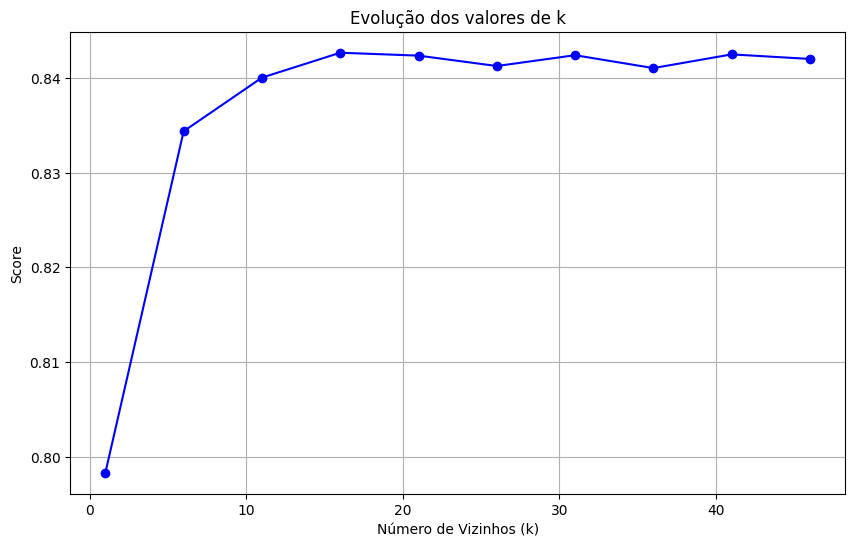

In [69]:
k = [i for i in range(1, 50, 5)] #definição do espaço de busca de k
scores = [] #armazenamento do valor de perfomance em cada iteração

for x in k:
    knn = KNeighborsClassifier(n_neighbors = x) #modelo com k vizinhos 
    vscore = cross_val_score(knn, X_train, y_train.values.ravel(), cv=10).mean() #avaliação do desempenho por 10-fold cross validation (cv = 10)
    scores.append(vscore)
    
max_score_ind = scores.index(np.max(scores)) #índice do score máximo
best_k = k[max_score_ind] #k correspondente ao valor do score máximo
print("Melhor k:", best_k) #imprimir melhor k

#plotar gráfico com a evolução do score de acordo com os valores de k
plt.figure(figsize=(10, 6))
plt.plot(k, scores, marker='o', linestyle='-', color='b')
plt.title('Evolução dos valores de k')
plt.xlabel('Número de Vizinhos (k)')
plt.ylabel('Score')
plt.grid(True)
plt.show()

## 8. Treinar modelo e validar com validação cruzada

In [70]:
knn = KNeighborsClassifier(n_neighbors= best_k) #criação do modelo final com k otimizado
acc =[] #armazenar valores de acurária 

In [71]:
kf = KFold(n_splits= 10, shuffle=True, random_state=42) #10-fold cross validation

#realizar validação cruzada
for train_index, val_index in kf.split(X_train):
    #divisão do conjunto de treino em splits de treino e validação para cada iteração
    xtrain, xval = X_train.iloc[train_index], X_train.iloc[val_index]
    ytrain, yval = y_train.iloc[train_index], y_train.iloc[val_index]

    knn.fit(xtrain, ytrain.values.ravel())

    y_pred = knn.predict(xval)

    accuracy = accuracy_score(yval, y_pred) #calcular acurácia para cada iteração da validação cruzada no conjunto de treinamento
    acc.append(accuracy)
    
accuracy = np.mean(acc) #acurácia média no conjunto de treinamento
print(f"Acurácia média no conjunto de treinamento: {accuracy:.4f}")


Acurácia média no conjunto de treinamento: 0.8415


## 10. Avaliação no conjunto de teste

In [72]:
#verificação da acurácia do modelo no conjunto de teste
knn.fit(X_train, y_train.values.ravel())
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia no conjunto de teste: {accuracy:.4f}")

Acurácia no conjunto de teste: 0.8458


In [73]:
y_preds = knn.predict_proba(X_test)[:, 1]

AUC: 0.8874


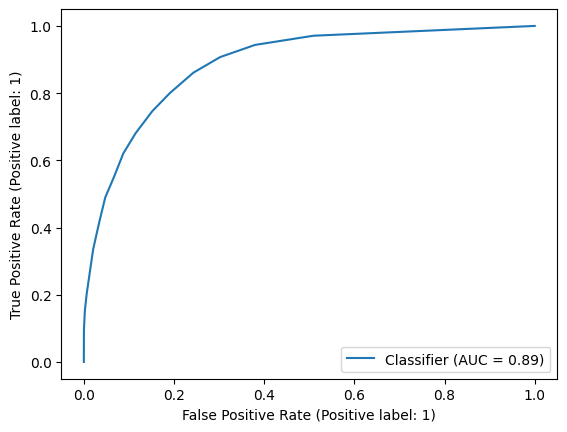

In [74]:
#avaliação do modelo por meio da área abaixo da curva ROC
auc = roc_auc_score(y_test, y_preds)
print(f"AUC: {auc:.4f}")

#plotar curva ROC
RocCurveDisplay.from_predictions(y_test, y_preds)
plt.show()


## 11. Matriz de confusão

In [75]:
y_scores = [0 if x < 0.5 else 1 for x in y_preds] #binarização das predições sob threshold de 50%

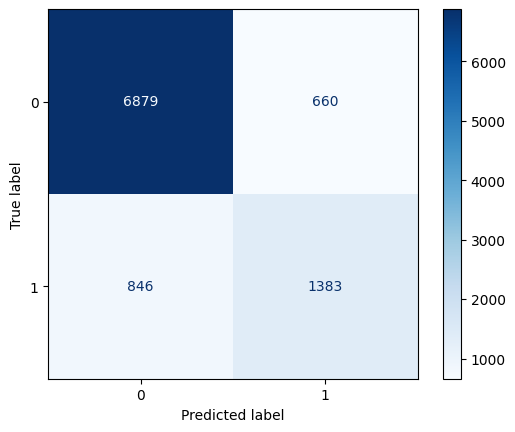

In [76]:
#fazer matriz de confusão para acessar o perfil de erros do modelo
cm = confusion_matrix(y_test, y_scores)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot(cmap='Blues')
plt.show()

## 12. Submissão

In [77]:
#formatação das predições para submissão final
pred = knn.predict(final_test)
pred = ['>50K' if x == 1 else '<=50K' for x in pred]
Id = [i for i in range(0,len(final_test))]
df = pd.DataFrame(({'Id':Id, 'income':pred}))
df.head(10)

,Id,income
0,0,<=50K
1,1,>50K
2,2,<=50K
3,3,<=50K
4,4,>50K
5,5,<=50K
6,6,>50K
7,7,>50K
8,8,<=50K
9,9,<=50K


In [78]:
df.to_csv("submission.csv",index=False) #salvar em arquivo .csv